## ECoG and pose dataset

*Falafel. NMA DeepLearning 2022*

paper - https://www.nature.com/articles/s41597-022-01280-y

The data files are available on The DANDI Archive (https://doi.org/10.48324/dandi.000055/0.220127.0436)47, in the Neurodata Without Borders: Neurophysiology 2.0 (NWB:N) format43. All datastreams and metadata have been combined into a single file for each participant and day of recording, as indicated by the file name. For example, sub-01_ses-3_behavior+ecephys.nwb contains data from participant P01 on recording day 3. We used PyNWB 1.4.0 to load and interact with these data files. Table 1 shows the location of all main variables within each data file.

Each file contains continuous ECoG and pose data over a 24-hour period, with units of and pixels, respectively. ECoG data is located under\acquisition\ElectricalSeries as a pynwb.ecephys.ElectricalSeries variable. Pose data can be found under\processing\behavior\data_interfaces\Position as an pynwb.behavior.Position variable. Pose data is provided for the left/right ear (L_Ear, R_Ear), shoulder (L_Shoulder, R_Shoulder), elbow (L_Elbow, R_Elbow), and wrist (L_Wrist, R_Wrist), as well as the nose (Nose).

In addition to these core datastreams, each file contains relevant metadata. Contralateral wrist movement events are located in\processing\behavior\data_interfaces\ReachEvents as an ndx_events.events.Events variable. Quantitative neural and behavioral features for each event can be found in\intervals\reaches as a pynwb.epoch.TimeIntervals table with columns for each feature. Coarse behavioral labels are included in\intervals\epochs as a pynwb.epoch.TimeIntervals table. Each row contains the label along with the start and stop time in seconds.

We also include electrode-specific metadata in\electrodes as a hdmf.common.table.DynamicTable. Columns contain different metadata features, such as Montreal Neurological Institute (MNI) x, y, z coordinates and electrode group names. Electrode groups were named by clinicians based on their location in the brain. This table also contains the standard deviation, kurtosis, and median absolute deviation for each electrode computed over the entire recording file (excluding non-numeric values). Electrodes that we identified as noisy based on abnormal standard deviation and kurtosis are marked as False under the ‘good’ column. Table 2 shows the number of good electrodes that remain for each participant during the first available day of recording. We have also included the R2 scores obtained from regressing ECoG spectral power on the 10 quantitative event features for each participant’s wrist movement events18. Low-frequency power (used for low_freq_R2) indicates power between 8–32 Hz, while high-frequency power (used for high_freq_R2) denotes power between 76–100 Hz.

## Streaming dataset data

Example code from dataset creators: https://github.com/BruntonUWBio/ajile12-nwb-data/blob/main/stream_dashboard.ipynb

Streaming from nwb tutorial:
https://pynwb.readthedocs.io/en/stable/tutorials/advanced_io/streaming.html



### Attention
**ros3 error:**
```bash
pip uninstall h5py

conda install -c conda-forge h5py
```
**"driver" param not found error**
```bash
conda update pynwb
```

#### Imports

In [4]:
#!pip install git+https://github.com/catalystneuro/brunton-lab-to-nwb.git
#!pip install nilearn
#!pip install mne
#!pin install dandi

In [1]:
print("Importing modules...")

# essentials
import os
import sys
import time
import warnings
from tqdm import tqdm

# science
import numpy as np
import pandas as pd
import scipy as sp


# for neural data
import mne
import nilearn
from scipy import signal, stats

# for nwb files and AJILE dataset
from brunton_lab_to_nwb.brunton_widgets import BruntonDashboard
from dandi.dandiapi import DandiAPIClient
from pynwb import NWBHDF5IO

import dandi

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import rc
#rc('font',**{'family':'sans-serif'})
#rc('text', usetex=True)
#rc('text.latex',preamble=r'\usepackage[utf8]{inputenc}')
#rc('text.latex',preamble=r'\usepackage[russian]{babel}')
#rc('axes', **{'titlesize': '16', 'labelsize': '16'})
#rc('legend', **{'fontsize': '16'})
#rc('figure', **{'figsize': (12, 8)})

warnings.filterwarnings("ignore")
print("Module import successful.")

Importing modules...
Module import successful.


In [2]:
sbj, session = 9, 3
use_cloud_file = True

fname = "sub-{0:>02d}_ses-{1:.0f}_behavior+ecephys.nwb".format(sbj, session)
local_fpath = "sub-{0:>02d}_ses-{1:.0f}_behavior+ecephys.nwb".format(sbj, session)
cloud_fpath = "sub-{0:>02d}/sub-{0:>02d}_ses-{1:.0f}_behavior+ecephys.nwb".format(sbj, session) 



In [3]:
warnings.filterwarnings("ignore")

if use_cloud_file:
    print("Retrieving cloud file...")
    with DandiAPIClient() as client:

        print("Starting a Dandi streaming client...")

        asset = client.get_dandiset("000055", "draft").get_asset_by_path(cloud_fpath)
        s3_path = asset.get_content_url(follow_redirects=1, strip_query=True)

    io = NWBHDF5IO(s3_path, mode='r', load_namespaces=True, driver='ros3')
else:
    print("Retrieving local file..")
    local_file_path = os.path.join(os.getcwd(), local_fpath)
    io = NWBHDF5IO(local_file_path, mode='r', load_namespaces=False)
    
print("Reading a file...")

nwb = io.read()

print(f"Returning nwb for {fname}")

Retrieving cloud file...


A newer version (0.45.1) of dandi/dandi-cli is available. You are using 0.45.0


Starting a Dandi streaming client...
Reading a file...
Returning nwb for sub-09_ses-3_behavior+ecephys.nwb


In [ ]:
# run to open a dashboard

if use_cloud_file:
    board = BruntonDashboard(nwb, tab1='stream')
else:
    board = BruntonDashboard(nwb, tab1='local')
    
board

In [7]:
neural_data = nwb.acquisition['ElectricalSeries'].data

print("Neural data shape: ", neural_data.shape)
n_times, n_chan = neural_data.shape
SF = nwb.acquisition['ElectricalSeries'].rate
print("Sampling rate: ", SF)

info = mne.create_info(n_chan, sfreq=SF)

max_time = 100 #sec
mne_data_chunk = mne.io.RawArray(neural_data[:int(max_time * SF)].reshape(n_chan, -1), info)

Neural data shape:  (43200000, 126)
Sampling rate:  500.0
Creating RawArray with float64 data, n_channels=126, n_times=50000
    Range : 0 ... 49999 =      0.000 ...    99.998 secs
Ready.


In [8]:
print(len(list(nwb.processing['behavior']['ReachEvents'].timestamps)))

15


### Reach durations

(array([2., 1., 0., 4., 3., 1., 0., 0., 3., 1.]),
 array([0.6 , 0.73, 0.86, 0.99, 1.12, 1.25, 1.38, 1.51, 1.64, 1.77, 1.9 ]),
 <BarContainer object of 10 artists>)

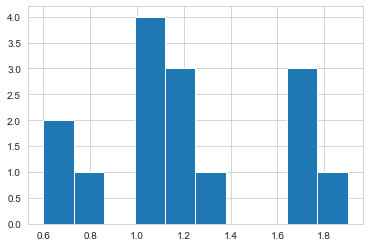

In [9]:
plt.hist(np.array(nwb.intervals['reaches']['stop_time'].data) - np.array(nwb.intervals['reaches']['start_time'].data))

In [10]:
list(nwb.intervals['reaches']['start_time'].data)[:10]

[24077.1,
 24262.754,
 34223.492999999995,
 34267.593,
 39710.516,
 41278.43,
 62912.246,
 62953.312999999995,
 63344.012,
 63620.388]

In [11]:
coarse_labels = nwb.intervals['epochs'].to_dataframe()

In [12]:
coarse_labels.groupby('labels').count()

,start_time,stop_time
labels,,
,28,28
Blocklist (Camera move/zoom),11,11
Blocklist (Clinical procedure),5,5
Blocklist (Data break),713,713
Blocklist (Hands under blanket),6,6
Blocklist (Private time),3,3
Blocklist (Tether/bandage),22,22
"Eat, Talk",5,5
Inactive,61,61


In [13]:
nwb.intervals['reaches']

reaches pynwb.epoch.TimeIntervals at 0x140251513330512
Fields:
  colnames: ['start_time' 'stop_time' 'Reach_magnitude_px' 'Reach_angle_degrees'
 'Onset_speed_px_per_sec' 'Speech_ratio' 'Bimanual_ratio'
 'Bimanual_overlap' 'Bimanual_class']
  columns: (
    start_time <class 'hdmf.common.table.VectorData'>,
    stop_time <class 'hdmf.common.table.VectorData'>,
    Reach_magnitude_px <class 'hdmf.common.table.VectorData'>,
    Reach_angle_degrees <class 'hdmf.common.table.VectorData'>,
    Onset_speed_px_per_sec <class 'hdmf.common.table.VectorData'>,
    Speech_ratio <class 'hdmf.common.table.VectorData'>,
    Bimanual_ratio <class 'hdmf.common.table.VectorData'>,
    Bimanual_overlap <class 'hdmf.common.table.VectorData'>,
    Bimanual_class <class 'hdmf.common.table.VectorData'>
  )
  description: Features of each reach
  id: id <class 'hdmf.common.table.ElementIdentifiers'>